In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, precision_recall_curve, auc,make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE
#import warnings
#warnings.filterwarnings('ignore')
import os

In [2]:
data_path = os.path.dirname(os.getcwd())

In [3]:
data = pd.read_csv(data_path+'/Data/Class imbalance/creditcard.csv')
#data.Class.replace(["'0'","'1'"],[0,1],inplace=True)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [5]:
data['Class'].value_counts() #Label counts

0    284315
1       492
Name: Class, dtype: int64

In [6]:
data.isna().values.any() #Check if any NaN value

False

In [7]:
df_train, df_test = train_test_split(data, test_size=0.25, random_state=0)
train_x = df_train.drop('Class',axis=1)
test_x = df_test.drop('Class',axis=1)
train_y = df_train['Class']
test_y = df_test['Class']

In [8]:
def kprecision(y_true, y_predicted, k):
    idx = np.argsort(y_predicted)
    tp = np.sum(y_true[idx[-k:]])
    return tp/k

In [9]:
def aupr_scorer(test_y,y_pred):
    precision, recall, thresholds = precision_recall_curve(test_y,y_pred)
    aupr = auc(recall,precision)
    return aupr

In [10]:
aupr_cvscorer = make_scorer(aupr_scorer)

## Baseline 

In [11]:
parameters = {'n_estimators':[30,50,100],'max_leaf_nodes':[3,7,10,15]}
rf = RandomForestClassifier(criterion='entropy', random_state=0)
baseline = GridSearchCV(rf, parameters, cv=3, return_train_score=True, scoring=aupr_cvscorer).fit(train_x, train_y)
clf = baseline.best_estimator_.fit(train_x,train_y)
y_pred = clf.predict_proba(test_x)[:,1]

Baseline NLL loss: 0.0029165702827122428, precision@25: 1.0


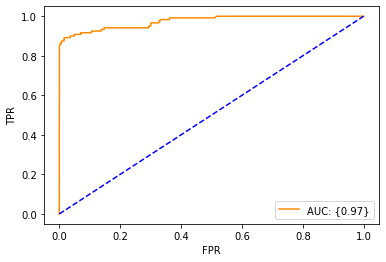

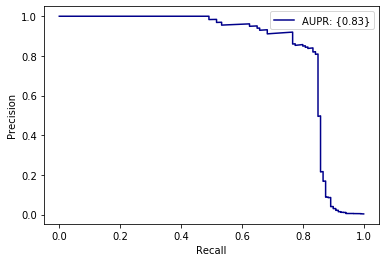

In [12]:
print('Baseline NLL loss: {}, precision@25: {}'.format(log_loss(test_y.values,y_pred), 
                                                                kprecision(test_y.values,y_pred,25)))
fpr, tpr, thresholds = roc_curve(test_y.values,y_pred)
plt.plot(fpr, tpr, color='darkorange',label = 'AUC: {%.2f}'%auc(fpr,tpr))
plt.plot([0,1],[0,1],color='blue',linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(test_y.values,y_pred)
aupr = auc(recall,precision)
plt.plot(recall, precision, color='darkblue', label='AUPR: {%.2f}'%aupr)
#plt.plot([0,1],[0,1],color='blue',linestyle='--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

## Undersampling 

100%|██████████| 4/4 [3:27:24<00:00, 3111.13s/it]


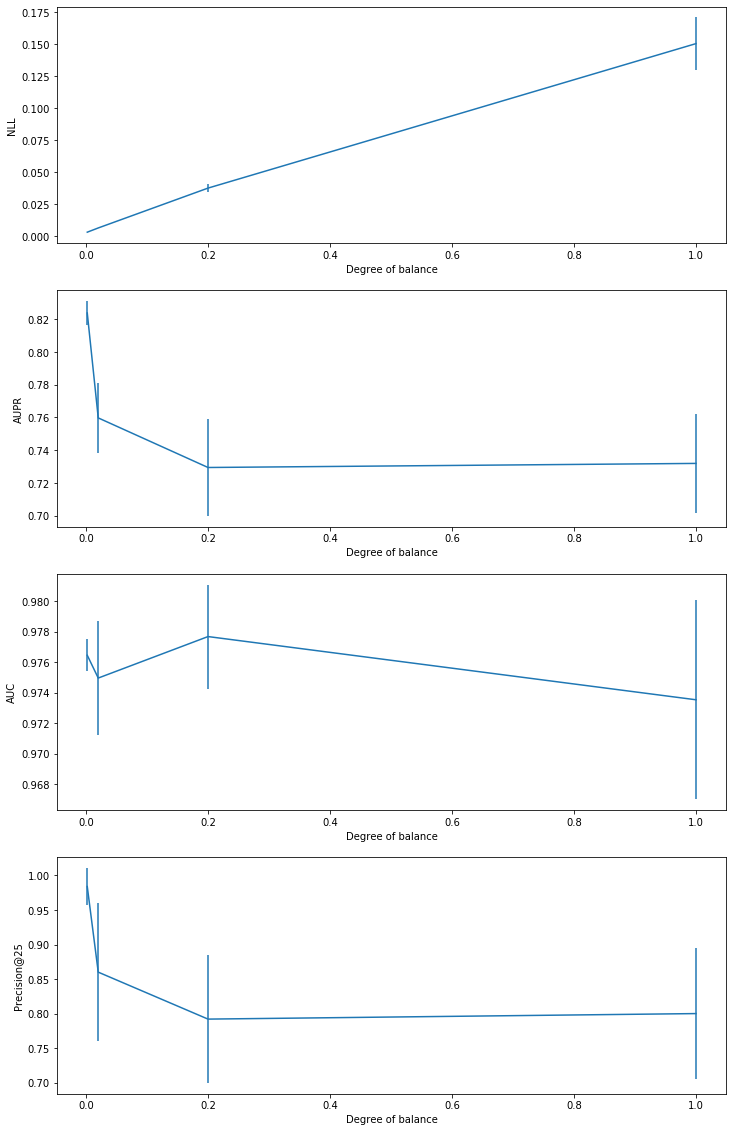

In [11]:
fractions = [1,0.2,0.02,0.002]
parameters = {'n_estimators':[30,50,100],'max_leaf_nodes':[3,7,10,15]}
n_bootstrap = 10
plt.figure(figsize=(12,20))
plt.subplot(211)
ax1 = plt.subplot(4, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Degree of balance')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(4, 1, 2)
#ax3.set_xscale('log')
ax2.set_xlabel('Degree of balance')
ax2.set_ylabel('AUPR')
ax3 = plt.subplot(4, 1, 3)
#ax2.set_xscale('log')
ax3.set_xlabel('Degree of balance')
ax3.set_ylabel('AUC')
ax4 = plt.subplot(4, 1, 4)
#ax3.set_xscale('log')
ax4.set_xlabel('Degree of balance')
ax4.set_ylabel('Precision@{}'.format(25))

mean_auc_us = []
std_auc_us = []
mean_aupr_us = []
std_aupr_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

for f in tqdm(fractions):
    aucs=[]
    precisions=[]
    log_losses=[]
    auprs = []
    for r in tqdm(range(n_bootstrap)):
        rus = RandomUnderSampler(sampling_strategy=f)
        train_x_resampled, train_y_resampled = rus.fit_resample(train_x, train_y)
        #print(train_y_resampled.value_counts())
        rf = RandomForestClassifier(criterion='entropy', random_state=0)
        cv_estimator = GridSearchCV(rf, parameters, cv=3, return_train_score=True, scoring=aupr_cvscorer).fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auprs.append(aupr_scorer(test_y.values,y_pred))
        aucs.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(kprecision(test_y.values,y_pred,25))
    mean_aupr_us.append(np.mean(auprs))
    std_aupr_us.append(np.std(auprs))
    mean_auc_us.append(np.mean(aucs))
    std_auc_us.append(np.std(aucs))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_aupr_us, std_aupr_us)
ax3.errorbar(fractions, mean_auc_us, std_auc_us)
ax4.errorbar(fractions, mean_prec_us, std_prec_us)

plt.show()



## Undersampling but matching test distribution

In [15]:
n_0 = train_y.size-train_y.sum()
n_1 = train_y.sum() 
n_0, n_1

(3204, 546)

In [17]:
train_y_resampled.sum()/(train_y_resampled.size-train_y_resampled.sum())

0.18001978239366964

In [21]:
3204/0.18

17800.0

100%|██████████| 5/5 [36:08<00:00, 433.62s/it]


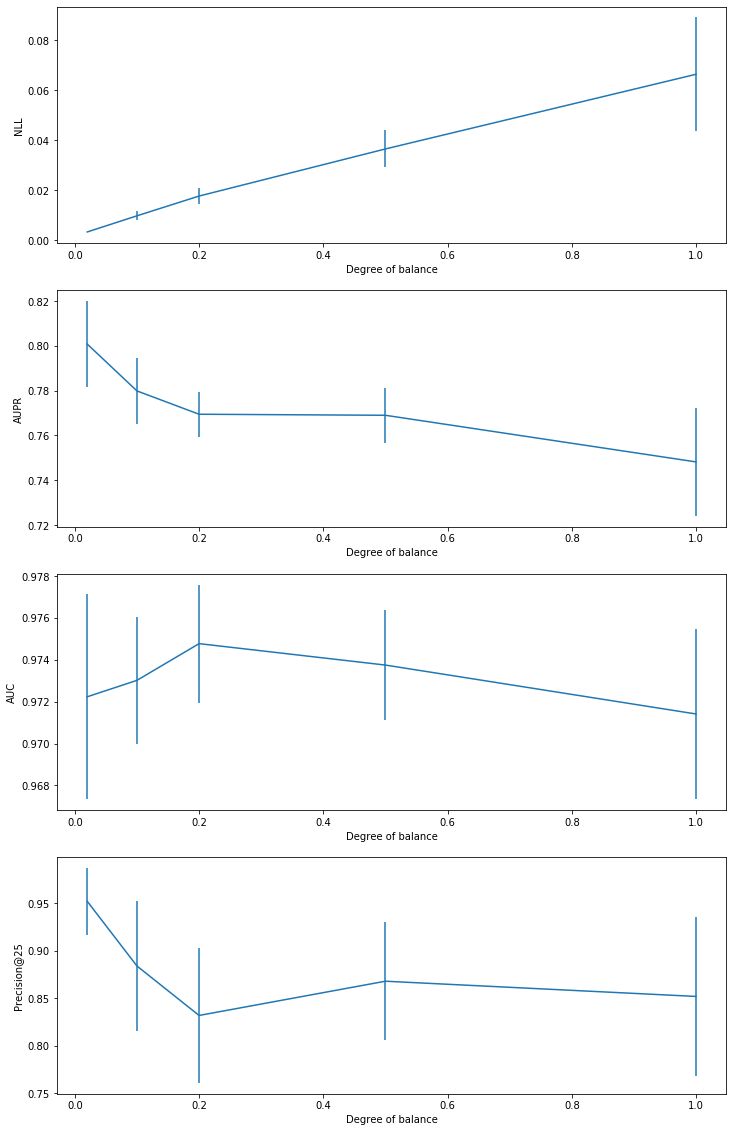

In [15]:
fractions = [1,0.5,0.2,0.1,0.02]
parameters = {'n_estimators':[30,50,100],'max_leaf_nodes':[3,7,10,15]}
n_bootstrap = 10
plt.figure(figsize=(12,20))
plt.subplot(211)
ax1 = plt.subplot(4, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Degree of balance')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(4, 1, 2)
#ax3.set_xscale('log')
ax2.set_xlabel('Degree of balance')
ax2.set_ylabel('AUPR')
ax3 = plt.subplot(4, 1, 3)
#ax2.set_xscale('log')
ax3.set_xlabel('Degree of balance')
ax3.set_ylabel('AUC')
ax4 = plt.subplot(4, 1, 4)
#ax3.set_xscale('log')
ax4.set_xlabel('Degree of balance')
ax4.set_ylabel('Precision@{}'.format(25))

mean_auc_us = []
std_auc_us = []
mean_aupr_us = []
std_aupr_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

n_0 = train_y.size-train_y.sum()
n_1 = train_y.sum() 

for f in tqdm(fractions):
    aucs=[]
    precisions=[]
    log_losses=[]
    auprs = []
    for r in tqdm(range(1,n_bootstrap+1)):
        rus = RandomUnderSampler(sampling_strategy=f, random_state=r)
        train_x_resampled, train_y_resampled = rus.fit_resample(train_x, train_y)
        #print(train_y_resampled.value_counts())
        cw = {0:f*n_0/(1+f),1:1*n_1/(1+f)}
        rf = RandomForestClassifier(criterion='entropy', random_state=10, class_weight=cw)
        cv_estimator = GridSearchCV(rf, parameters, cv=3, return_train_score=True, scoring=aupr_cvscorer).fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auprs.append(aupr_scorer(test_y.values,y_pred))
        aucs.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(kprecision(test_y.values,y_pred,25))
    mean_aupr_us.append(np.mean(auprs))
    std_aupr_us.append(np.std(auprs))
    mean_auc_us.append(np.mean(aucs))
    std_auc_us.append(np.std(aucs))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_aupr_us, std_aupr_us)
ax3.errorbar(fractions, mean_auc_us, std_auc_us)
ax4.errorbar(fractions, mean_prec_us, std_prec_us)
plt.show()



## Oversampling 

 10%|█         | 1/10 [1:29:31<13:25:43, 5371.54s/it]

KeyboardInterrupt: 

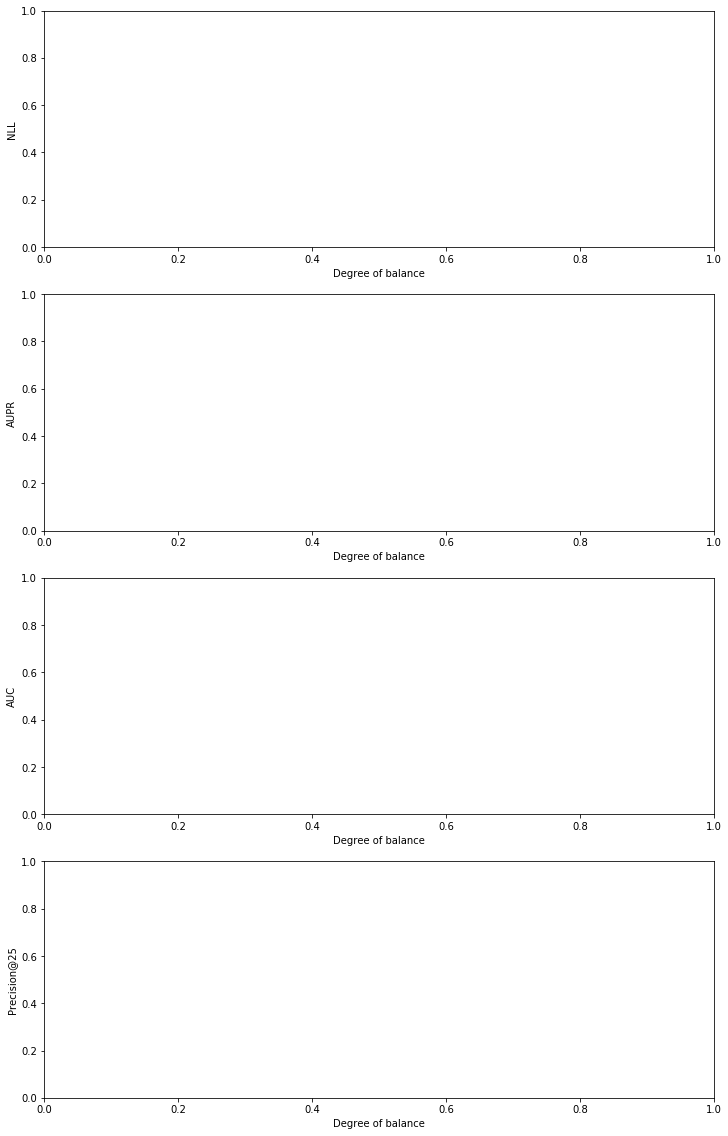

In [16]:
fractions = [1,0.5,0.2,0.1,0.02]
parameters = {'n_estimators':[30,50,100],'max_leaf_nodes':[3,7,10,15]}
n_bootstrap = 10
plt.figure(figsize=(12,20))
plt.subplot(211)
ax1 = plt.subplot(4, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Degree of balance')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(4, 1, 2)
#ax3.set_xscale('log')
ax2.set_xlabel('Degree of balance')
ax2.set_ylabel('AUPR')
ax3 = plt.subplot(4, 1, 3)
#ax2.set_xscale('log')
ax3.set_xlabel('Degree of balance')
ax3.set_ylabel('AUC')
ax4 = plt.subplot(4, 1, 4)
#ax3.set_xscale('log')
ax4.set_xlabel('Degree of balance')
ax4.set_ylabel('Precision@{}'.format(25))

mean_auc_us = []
std_auc_us = []
mean_aupr_us = []
std_aupr_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

for f in tqdm(fractions):
    aucs=[]
    precisions=[]
    log_losses=[]
    auprs = []
    for r in tqdm(range(n_bootstrap)):
        ros = RandomOverSampler(sampling_strategy=f,random_state=r)
        train_x_resampled, train_y_resampled = ros.fit_resample(train_x, train_y)
        #print(train_y_resampled.value_counts())
        rf = RandomForestClassifier(criterion='entropy', random_state=0)
        cv_estimator = GridSearchCV(rf, parameters, cv=3, return_train_score=True, scoring=aupr_cvscorer).fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auprs.append(aupr_scorer(test_y.values,y_pred))
        aucs.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(kprecision(test_y.values,y_pred,25))
    mean_aupr_us.append(np.mean(auprs))
    std_aupr_us.append(np.std(auprs))
    mean_auc_us.append(np.mean(aucs))
    std_auc_us.append(np.std(aucs))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_aupr_us, std_aupr_us)
ax3.errorbar(fractions, mean_auc_us, std_auc_us)
ax4.errorbar(fractions, mean_prec_us, std_prec_us)
plt.show()



100%|██████████| 6/6 [15:03<00:00, 150.60s/it]


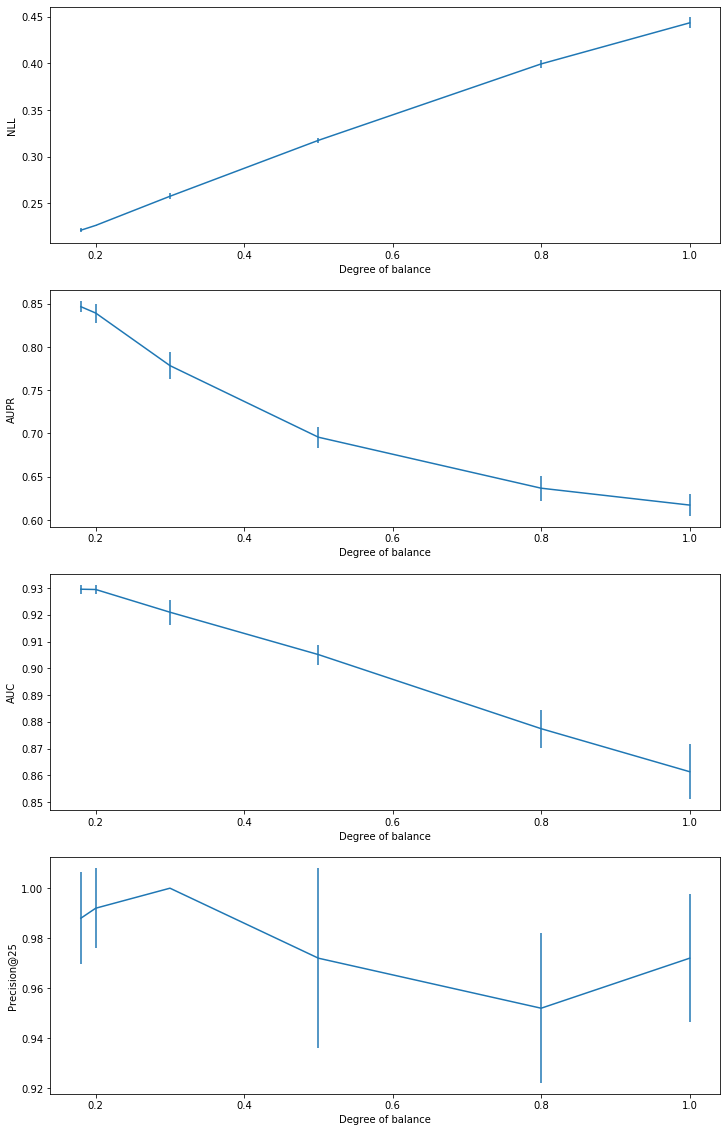

In [14]:
fractions = [1,0.5,0.2,0.1,0.02]
parameters = {'n_estimators':[30,50,100],'max_leaf_nodes':[3,7,10,15]}
n_bootstrap = 10
plt.figure(figsize=(12,20))
plt.subplot(211)
ax1 = plt.subplot(4, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Degree of balance')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(4, 1, 2)
#ax3.set_xscale('log')
ax2.set_xlabel('Degree of balance')
ax2.set_ylabel('AUPR')
ax3 = plt.subplot(4, 1, 3)
#ax2.set_xscale('log')
ax3.set_xlabel('Degree of balance')
ax3.set_ylabel('AUC')
ax4 = plt.subplot(4, 1, 4)
#ax3.set_xscale('log')
ax4.set_xlabel('Degree of balance')
ax4.set_ylabel('Precision@{}'.format(25))

mean_auc_us = []
std_auc_us = []
mean_aupr_us = []
std_aupr_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

for f in tqdm(fractions):
    aucs=[]
    precisions=[]
    log_losses=[]
    auprs = []
    for r in tqdm(range(n_bootstrap)):
        os = SMOTE(sampling_strategy=f,random_state=r)
        train_x_resampled, train_y_resampled = os.fit_resample(train_x, train_y)
        #print(train_y_resampled.value_counts())
        rf = RandomForestClassifier(criterion='entropy', random_state=0)
        cv_estimator = GridSearchCV(rf, parameters, cv=3, return_train_score=True, scoring=aupr_cvscorer).fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auprs.append(aupr_scorer(test_y.values,y_pred))
        aucs.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(kprecision(test_y.values,y_pred,25))
    mean_aupr_us.append(np.mean(auprs))
    std_aupr_us.append(np.std(auprs))
    mean_auc_us.append(np.mean(aucs))
    std_auc_us.append(np.std(aucs))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_aupr_us, std_aupr_us)
ax3.errorbar(fractions, mean_auc_us, std_auc_us)
ax4.errorbar(fractions, mean_prec_us, std_prec_us)
plt.show()



## Learning curve analysis


100%|██████████| 10/10 [52:57<00:00, 258.97s/it]

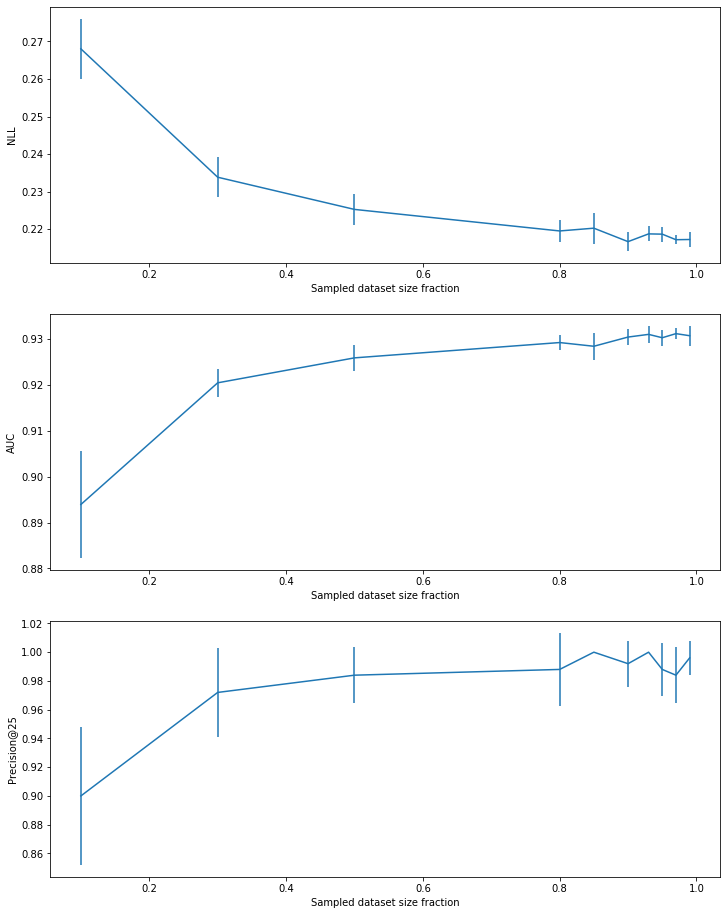

In [17]:
fractions = [0.99,0.97,0.95,0.93,0.9,0.85,0.8,0.5,0.3,0.1]
parameters = {'n_estimators':[30,50,100],'max_leaf_nodes':[3,7,10,15]}
n_bootstrap = 10
plt.figure(figsize=(12,16))
plt.subplot(211)
ax1 = plt.subplot(3, 1, 1)
#ax1.set_xscale('log')
ax1.set_xlabel('Sampled dataset size fraction')
ax1.set_ylabel('NLL')
ax2 = plt.subplot(3, 1, 2)
#ax2.set_xscale('log')
ax2.set_xlabel('Sampled dataset size fraction')
ax2.set_ylabel('AUC')
ax3 = plt.subplot(3, 1, 3)
#ax3.set_xscale('log')
ax3.set_xlabel('Sampled dataset size fraction')
ax3.set_ylabel('Precision@{}'.format(25))
mean_auc_us = []
std_auc_us = []
std_nll_us = []
mean_nll_us = []
std_prec_us = []
mean_prec_us = []

for f in tqdm(fractions):
    auc=[]
    precisions=[]
    log_losses=[]
    for r in range(n_bootstrap):
        train_x_resampled, _, train_y_resampled, _ = train_test_split(train_x, train_y, train_size=f)
        #print(train_y_resampled.value_counts())
        rf = RandomForestClassifier(criterion='entropy', random_state=0)
        cv_estimator = GridSearchCV(rf, parameters, cv=3, return_train_score=True, scoring='roc_auc').fit(train_x_resampled, train_y_resampled)
        clf = cv_estimator.best_estimator_.fit(train_x_resampled,train_y_resampled)
        y_pred = clf.predict_proba(test_x)[:,1]
        auc.append(roc_auc_score(test_y.values,y_pred))
        log_losses.append(log_loss(test_y.values,y_pred))
        precisions.append(precision(test_y.values,y_pred,25))
    mean_auc_us.append(np.mean(auc))
    std_auc_us.append(np.std(auc))
    mean_nll_us.append(np.mean(log_losses))
    std_nll_us.append(np.std(log_losses))
    mean_prec_us.append(np.mean(precisions))
    std_prec_us.append(np.std(precisions))
    
ax1.errorbar(fractions, mean_nll_us, std_nll_us)
ax2.errorbar(fractions, mean_auc_us, std_auc_us)
ax3.errorbar(fractions, mean_prec_us, std_prec_us)

plt.show()

